In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import os
import math
# import data_loader
# import ResNet as models
from torch.utils import model_zoo
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
from sklearn.manifold import TSNE
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from sklearn.decomposition import PCA
%matplotlib inline


In [2]:
#!/usr/bin/env python
# encoding: utf-8

import torch

def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    n_samples = int(source.size()[0])+int(target.size()[0])
    total = torch.cat([source, target], dim=0)
    total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    L2_distance = ((total0-total1)**2).sum(2)
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
    return sum(kernel_val)#/len(kernel_val)


def mmd_rbf_accelerate(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    batch_size = int(source.size()[0])
    kernels = guassian_kernel(source, target,
        kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
    loss = 0
    for i in range(batch_size):
        s1, s2 = i, (i+1)%batch_size
        t1, t2 = s1+batch_size, s2+batch_size
        loss += kernels[s1, s2] + kernels[t1, t2]
        loss -= kernels[s1, t2] + kernels[s2, t1]
    return loss / float(batch_size)

def mmd_rbf_noaccelerate(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    batch_size = int(source.size()[0])
    kernels = guassian_kernel(source, target,
                              kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
    XX = kernels[:batch_size, :batch_size]
    YY = kernels[batch_size:, batch_size:]
    XY = kernels[:batch_size, batch_size:]
    YX = kernels[batch_size:, :batch_size]
    loss = torch.mean(XX + YY - XY -YX)
    return loss

import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
import torch


__all__ = ['ResNet', 'resnet50']


model_urls = {
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
}


def conv3x3(in_planes, out_planes, stride=1,groups=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)



class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, norm_layer=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000,zero_init_residual=False,
                 groups=1, width_per_group=64, norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.inplanes = 64
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], norm_layer=norm_layer)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, norm_layer=norm_layer)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, norm_layer=norm_layer)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, norm_layer=norm_layer)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1,norm_layer=None):
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        #x=self.fc(x)

        return x

class DANNet(nn.Module):

    def __init__(self, num_classes=31):
        super(DANNet, self).__init__()
        self.sharedNet = resnet50(True)
        self.cls_fc = nn.Linear(2048, num_classes)

    def forward(self, source, target):
        loss = 0
        source = self.sharedNet(source)
        if self.training == True:
            target = self.sharedNet(target)
            #loss += mmd.mmd_rbf_accelerate(source, target)
            loss += mmd_rbf_noaccelerate(source, target)

        source = self.cls_fc(source)
        #target = self.cls_fc(target)

        return source, loss
    
    def predict(self, X):
      loss = 0
      X = self.sharedNet(X)

      return X, loss

def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


In [3]:
from torchvision import datasets, transforms
import torch
import numpy as np
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

def load_data(data_folder, batch_size, train, kwargs, val_split=0.8,target=False):
    transform = {
        'train': transforms.Compose(
            [transforms.Resize([256, 256]),
                transforms.RandomCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])]),
        'test': transforms.Compose(
            [transforms.Resize([224, 224]),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])])
        }
    data = datasets.ImageFolder(root = data_folder, transform=transform['train' if train else 'test'])
    if target:
      _, data_idx = train_test_split(list(range(len(data))), test_size=val_split, random_state = 2)
      train_idx, val_idx = train_test_split(data_idx, test_size=0.3, random_state = 1)
      target_train_data, target_val_data = Subset(data, train_idx), Subset(data, val_idx)
      
      target_train_data_loader = torch.utils.data.DataLoader(target_train_data, batch_size=batch_size, shuffle=True, **kwargs, drop_last = True if train else False)
      target_val_data_loader = torch.utils.data.DataLoader(target_val_data, batch_size=batch_size, shuffle=True, **kwargs, drop_last = True if train else False)
      return target_train_data_loader, target_val_data_loader

    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, **kwargs, drop_last = True if train else False)
    return data_loader

In [4]:
# Training settings
batch_size = 32
iteration = 100
lr = 0.01
momentum = 0.9
no_cuda = False
seed = 8
log_interval = 10
l2_decay = 5e-4


cuda = not no_cuda and torch.cuda.is_available()

torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

#TODO:
best_acc = 0



In [6]:
folder_tar = r"E:/code/animal10/animal-5/"
tgt_train_loader, tgt_test_loader = load_data(
    folder_tar, batch_size, True, kwargs, target=True)



In [7]:

print("target_train: {}, target_test: {}".format(
    len(tgt_train_loader.dataset), len(tgt_test_loader.dataset)))

tgt_dataset_len = len(tgt_test_loader.dataset)
tgt_loader_len = len(tgt_train_loader)


target_train: 7328, target_test: 3141


In [8]:
model = DANNet(num_classes=5)
# model = resnet50(pretrained=True)

In [229]:
PATH = r"E:\code\transferlearning-master\code\deep\OwnDAN\models\2_15_data"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [231]:
model.cuda()
model.eval()
test_loss = 0
correct = 0

nb_classes = 5
confusion_matrix = torch.zeros(nb_classes, nb_classes)

features = []
labels = []
preds = []
with torch.no_grad():
    for tgt_test_data, tgt_test_label in tgt_test_loader:
        if cuda:
            tgt_test_data, tgt_test_label = tgt_test_data.cuda(), tgt_test_label.cuda()
        tgt_test_data, tgt_test_label = Variable(
            tgt_test_data), Variable(tgt_test_label)
        tgt_pred_tsne, mmd_loss_tsne = model.predict(tgt_test_data)
        tgt_pred, mmd_loss = model(tgt_test_data, tgt_test_data)
        features.append(tgt_pred_tsne.cpu().numpy())
        labels.append(tgt_test_label.cpu().numpy())
#         print(tgt_pred[0])
#         break
        test_loss += F.nll_loss(F.log_softmax(tgt_pred, dim=1),
                                tgt_test_label, reduction='sum').item()  # sum up batch loss
        # get the index of the max log-probability
        pred = tgt_pred.data.max(1)[1]
        preds.append(pred.cpu().numpy())
        correct += pred.eq(tgt_test_label.data.view_as(pred)).cpu().sum()

        # confusion matrix
        for t, p in zip(tgt_test_label.view(-1), pred.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

test_loss /= tgt_dataset_len
print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    tgt_test_loader.dataset.dataset.root, test_loss, correct, tgt_dataset_len,
    100. * correct / tgt_dataset_len))

print(confusion_matrix)
print("Per-class Accuracy:")
print(confusion_matrix.diag()/confusion_matrix.sum(1))


E:/code/animal10/animal-5/ set: Average loss: 0.3811, Accuracy: 2716/3141 (86.47%)

tensor([[898.,  72.,   5., 101.,  97.],
        [ 13., 560.,   0.,   4.,  36.],
        [  2.,   1., 490.,   1.,   0.],
        [ 44.,   1.,   1., 353.,   5.],
        [ 21.,  13.,   0.,   3., 415.]])
Per-class Accuracy:
tensor([0.7656, 0.9135, 0.9919, 0.8738, 0.9181])


In [232]:
features = np.array(features)
X = features.reshape((98*32, 2048))
X.shape
# X_subset = X[:1000]
# X_subset.shape

(3136, 2048)

In [233]:
labels = np.array(labels)
labels.shape
Y = labels.reshape((98*32,))
Y.shape
# Y_subset = Y[:1000]
# Y_subset.shape

(3136,)

In [235]:
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = Y
df['label'] = df['y'].apply(lambda i: str(i))




In [237]:
# df

In [238]:
pca = PCA(n_components=1000)
pca_result = pca.fit_transform(X)


In [239]:
pca_result.shape

(3136, 1000)

In [240]:
import seaborn as sns
  

In [261]:
fashion_tsne = TSNE(n_components=2, verbose=1, n_iter=270).fit_transform(pca_result)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3136 samples in 0.094s...
[t-SNE] Computed neighbors for 3136 samples in 13.031s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3136
[t-SNE] Computed conditional probabilities for sample 2000 / 3136
[t-SNE] Computed conditional probabilities for sample 3000 / 3136
[t-SNE] Computed conditional probabilities for sample 3136 / 3136
[t-SNE] Mean sigma: 4.696965
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.473145
[t-SNE] KL divergence after 270 iterations: 2.270853


In [262]:
fashion_tsne.shape

(3136, 2)

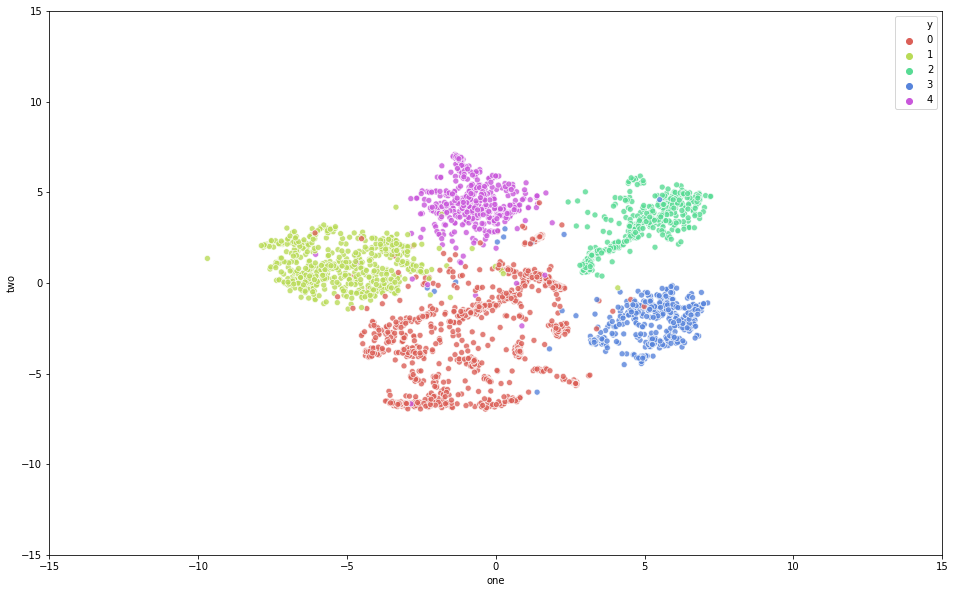

In [266]:
df['one'] = fashion_tsne[:,0]
df['two'] = fashion_tsne[:,1]
plt.figure(figsize=(16,10))
plt.ylim(-15, 15)
plt.xlim(-15, 15)

sns.scatterplot(
    x="one", y="two",
    hue="y",
    palette=sns.color_palette("hls",5),
    data=df,
    legend="full",
    alpha=0.8
)